# What is the value of a customer?

Exploring how we can classify a customer to som particular type.
The plan of attack is to do some:

1. Data exploration.
2. Do PCA to explore distribution of variance.
3. Explore outliers.
4. Cluster using GMM on the transformed.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
 

In [2]:
data = pd.read_csv('../ltv20160906_test.csv', delimiter='^')

In [3]:
data_80 = pd.read_csv('../ltv20160906_train.csv', delimiter='^')

In [4]:
data_all = pd.concat([data, data_80])

In [5]:
data_all['year'] = data_all['week'].apply(lambda y: int(y[0:4]))
data_all['week_n'] = data_all['week'].apply(lambda y: int(y[-2:]))

In [19]:
dataUS = data_all[data_all.jobCountry == 'US']
dataUS = dataUS.reset_index(drop=True)
dataUS['costmillicent'] = dataUS.costmillicent/1e7

In [22]:
dataUS.columns

Index([u'advertiserId', u'isDradisEmployer', u'salesTouched', u'week',
       u'costmillicent', u'jobCountry', u'company', u'employeeCount',
       u'dateCreated', u'firstRevenueDate', u'lastRevenueDate', u'isAdAgency',
       u'industry', u'type', u'state', u'city', u'conversionTime',
       u'hasDradisJob', u'sid', u'kw', u'outgoingEmail', u'outgoingCall',
       u'advertiserAgeWeek', u'spendAgeWeek', u'spendAgeWeek_c',
       u'advertiserAgeWeek_c', u'conversionTime_c', u'sales_touch', u'source',
       u'year', u'week_n'],
      dtype='object')

### Important Cols
advertiserId
week
costmillicent

In [28]:
## Only consider these columns.
columns = ['employeeCount', 'isDradisEmployer', 'salesTouched', 'employeeCount', 'isAdAgency', 
'industry', 'type', 'conversionTime_c', 'hasDradisJob', 'advertiserAgeWeek_c', 'advertiserAgeWeek_c',
'sales_touch', 'source']

In [32]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [30]:
def remove_nans(df):
    nan_df = df[pd.isnull(df).any(axis=1)]
    for col in nan_df.columns:
        tmp = nan_df[col][pd.isnull(nan_df[col])]
        if len(tmp) >= 1:
            #print "These features have NULLs to signify the absence of such a feature:"
            print col, len(tmp)
            df[col] = df[col].fillna(0.)
    print np.shape(df)
    return df

In [29]:
## Define and remove repeat outliers
def remove_outliers(df):
    outliers  = []
    for feature in df.columns:
        
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        
        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        
        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)
        
        outliers = list(outliers + df[~((df[feature] >= Q1 - step) & \
                                                  (df[feature] <= Q3 + step))].index.tolist())
    
    # Select the indices for data points you wish to remove
    from collections import Counter
    counts = Counter(outliers)
    outliers = sorted([value for value, count in counts.items() if count > 2])
    return outliers

In [ ]:
# Remove NaNs
data_clean = remove_nans(dataUS)
data_clean = preprocess_features(dataUS)
# Remove outliers
outliers = remove_outliers(data)
good_data = data_clean.drop(data_clean.index[outliers]).reset_index(drop = True)
good_data_X = good_data.drop(['costmillicent'], axis =1)
good_data_y =  good_data['costmillicent']
print "The dimensions of the data without outliers now is {}".format(np.shape(good_data_X))


(2345667, 31)


(0, 3.0)

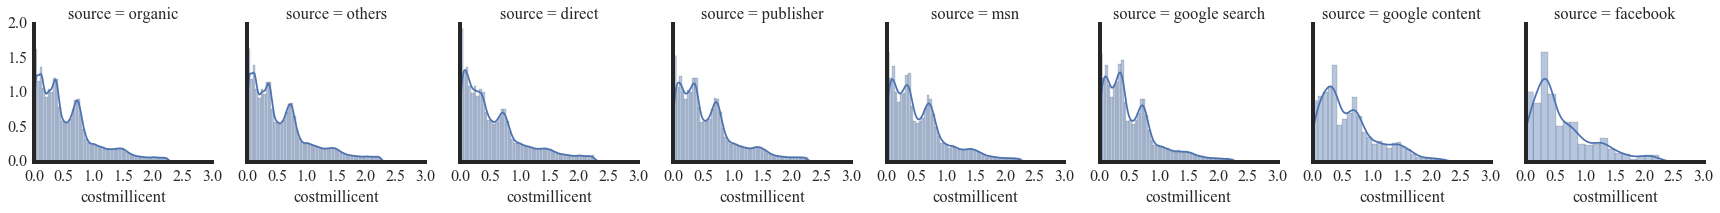

In [21]:



Q1 = np.percentile(dataUS['costmillicent'], 25)
Q3 = np.percentile(dataUS['costmillicent'], 75)
step = 1.5*(Q3-Q1)
outliers = list(dataUS[~((dataUS['costmillicent'] >= Q1 - step) & \
                                                  (dataUS['costmillicent'] <= Q3 + step))].index.tolist())
good_data = dataUS.drop(dataUS.index[outliers]).reset_index(drop = True)
g = sns.FacetGrid(good_data, col="source")  
g.map(sns.distplot, "costmillicent")  
plt.xlim(0,)

In [27]:
set(dataUS.week_n)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53}

In [49]:
dataUS.costmillicent.describe()

count    2.345667e+06
mean     1.158276e+07
std      3.228728e+07
min      6.880000e+02
25%      2.240000e+06
50%      5.231000e+06
75%      1.039000e+07
max      2.132475e+09
Name: costmillicent, dtype: float64

In [16]:
dataUS.head()

,advertiserId,isDradisEmployer,salesTouched,week,costmillicent,jobCountry,company,employeeCount,dateCreated,firstRevenueDate,...,outgoingCall,advertiserAgeWeek,spendAgeWeek,spendAgeWeek_c,advertiserAgeWeek_c,conversionTime_c,sales_touch,source,year,week_n
0,2505904,1,1,2015-06,1963000,US,Self,1-49,2015-02-01,2015-02-01,...,1,1,1,1,0,0,2,organic,2015,6
1,2505904,1,1,2015-05,493000,US,Self,1-49,2015-02-01,2015-02-01,...,0,0,0,0,0,0,0,organic,2015,5
2,2506921,1,1,2015-29,27870000,US,Central Medical Billing,1-49,2015-02-01,2015-02-02,...,0,24,23,23,0,1,0,organic,2015,29
3,2506921,1,1,2015-30,9487000,US,Central Medical Billing,1-49,2015-02-01,2015-02-02,...,0,25,24,24,0,1,0,organic,2015,30
4,2506921,1,1,2015-06,1155000,US,Central Medical Billing,1-49,2015-02-01,2015-02-02,...,0,1,0,0,0,1,0,organic,2015,6
